In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf

In [3]:
from tensorflow import keras

In [4]:
print(tf.__version__)
print(sys.version_info)

2.1.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)


In [5]:
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

matplotlib 3.1.1
numpy 1.17.2
pandas 0.25.1
sklearn 0.21.3
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [6]:
from sklearn.datasets import fetch_california_housing

housing= fetch_california_housing()

In [7]:
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test = train_test_split(
    housing.data, housing.target, random_state =7)

x_train,x_valid,y_train,y_valid = train_test_split(
    x_train_all,y_train_all,random_state=11)

print(x_train_all.shape,y_train_all.shape)
print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

(15480, 8) (15480,)
(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [8]:
x_train.shape[1:]

(8,)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)
x_test_scaled = scaler.fit_transform(x_test)

In [11]:
# 函數 API
input = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30,activation ='selu')(input)
hidden2 = keras.layers.Dense(30,activation='selu')(hidden1)

concat = keras.layers.concatenate([input,hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input],
                          outputs= [output])

model.summary()
model.compile(loss='mse',optimizer='adam')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_2[0][0]                    
                                                                 dense_1[0][0]                

In [19]:
# 子類API
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel,self).__init__()
        # 定義模型的層次
        self.hidden1_layer = keras.layers.Dense(30,activation='selu')
        self.hidden2_layer = keras.layers.Dense(30,activation='selu')
        self.output_layer = keras.layers.Dense(1)
        
    def call(self,input):
        # 完成模型的正向計算
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input,hidden2])
        output= self.output_layer(concat)
        return output

model_2 = WideDeepModel()
model_2.build(input_shape=(None,8)) # None 樣本數
model_2.compile(loss='mse',optimizer='adam')

In [37]:
# 多輸入
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])
hidden3 = keras.layers.Dense(30,activation='relu')(input_deep)
hidden4 = keras.layers.Dense(30,activation='relu')(hidden3)
concat_m = keras.layers.concatenate([input_wide,hidden4])
output_m = keras.layers.Dense(1)(concat_m)

model_3 = keras.models.Model(inputs = [input_wide,input_deep],
                                       outputs = [output_m])


In [38]:
x_train_scaled_wide = x_train_scaled[:,:5]
x_train_scaled_deep = x_train_scaled[:,2:]

x_valid_scaled_wide = x_valid_scaled[:,:5]
x_valid_scaled_deep = x_valid_scaled[:,2:]

x_test_scaled_wide = x_test_scaled[:,:5]
x_test_scaled_deep = x_test_scaled[:,2:]



In [39]:
history_3 = model_3.fit([x_train_scaled_wide,x_train_scaled_deep],
                        y_train,
                   validation_data= ([x_valid_scaled_wide,x_valid_scaled_deep],
                                     y_valid),
                   epochs=100,
                   callbacks=callbacks)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [20]:
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]

In [21]:
history = model_2.fit(x_train_scaled,y_train,
                   validation_data= (x_valid_scaled,y_valid),
                   epochs=100,
                   callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 70us/sample - loss: 1.1568 - val_loss: 0.5195
Epoch 2/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4937 - val_loss: 0.4722
Epoch 3/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4421 - val_loss: 0.4669
Epoch 4/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4276 - val_loss: 0.4619
Epoch 5/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4235 - val_loss: 0.4437
Epoch 6/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4101 - val_loss: 0.4487
Epoch 7/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4057 - val_loss: 0.4502
Epoch 8/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3962 - val_loss: 0.4294
Epoch 9/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.390

In [24]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

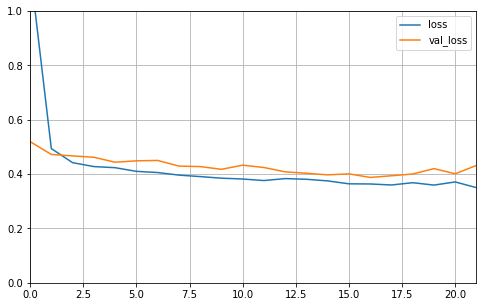

In [25]:
plot_learning_curves(history)

In [27]:
model_2.evaluate(x_test_scaled,y_test)

5160/5160 [==============================] - 0s 19us/sample - loss: 0.4467


0.4467381981916206